# "A Matter of Grayscale: Understanding Dicom Windows"
> "DICOM images can contain a high amount of voxel values and windowing can be thought of as a means of manipulating these values in order to change the appearance of the image so particular structures are highlighted"
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [medical_imaging, windowing, dicoms]
- image: images/windowing.PNG

## A Matter of Grayscale

DICOM images typically contain between 12–16 bits/pixel, which corresponds to approximately 4,096 to 65,536 shades of gray<sup>[1]</sup>.  Most medical displays and regular computer screens are often limited to 8 bits or 256 shades of gray.  There are high end medical displays that can display 1024 shades of gray (like the ones optimized for mammography).

However even with a computer screen that can display 256 shades of gray our eyes can typically only detect a **6%** change in grayscale<sup>[2]</sup>

![shades of gray](my_icons/gray.PNG)


That means we can typically only detect about $100/6$ = **17 shades of gray**

The [Hounsfield unit]<sup>[3]</sup> (**HU**) scale is a quantitative scale for describing radiodensity.  It applies a linear transformation where the radiodensity of distilled water at standard pressure and temperature (STP) is defined as **0 HU**, while the radiodensity of air at STP is defined as **-1000 HU**.

![HU range](my_icons/hu.PNG)

(Image credit<sup>[4]</sup>) Most images will require viewing between **-1000 HU** (which is a reference for air) and **+1000 HU** (which typically references hard bone).

So a DICOM image can have a range of **2000 HU** (from -1000 HU to +1000 HU) and if we wanted to display this range on a computer screen which can only display 256 shades of grey: $2000/256 = 8$. Then each shade of gray would have a difference of 8 HU.

The human eye can only detect a 6% change in grayscale so for humans to detect a difference in densities (within the image range of 2000 HU), each variation has to vary by: $256/17 * 8 = 120$ HU.  The difference between normal and pathologically altered tissue is usually a lot less than 120 HU and this is why applying `windows` is important.

## Windowing

**Windowing** can be thought of as a means of manipulating pixel values in order to change the apperance of an image so particular structures within the image are highlighted.

To futher explain how `windowing` works we use this [dataset](https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection), import the `fastai` libraries and load a test image.

In [33]:
#hide
from fastai.vision.all import *
from fastai.medical.imaging import *

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
plt.set_cmap('bone');

source = 'D:/Datasets/rsna_pulmonary'
files = get_dicom_files(source)
patient6 = files[6].dcmread()

<Figure size 504x504 with 0 Axes>

View the `pixel_array`

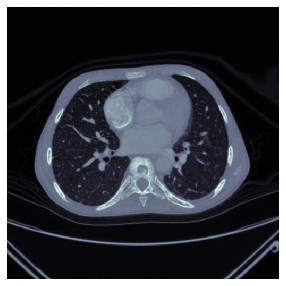

In [2]:
show_image(patient6.pixel_array, cmap=plt.cm.bone);

The difference when using `fastai` is that by default it will display the normalized image when the `show` function is used.

1 frame per file


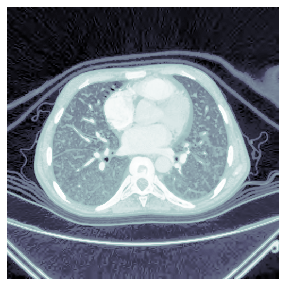

In [8]:
normalized = patient6.show(); normalized;

Clearly there is alot more depth displayed in the image.  However this can be an issue when trying to localize areas that are normal to those that have been pathologically altered due to a condition. In most cases the difference in Hounsfield units between normal and pathologically altered tissue can be very small.

![Tissue Densities](my_icons/tissues.png)

The normalized image displays a wide range of tissue densities(ranging from -1000HU (air) to around +1000HU (bone)).  As mentioned above a regular computer screen can only display 256 shades of grey and our eye can only deduct about a 6% change in grayscale<sup>[2]</sup>

The basis of applying `windows` is to focus down the 256 shades of grey into a narrow region of Hounsfled units that contain the relevant densities of tissues we may be interested in.

### `Fastai`'s in-built windows

The fastai medical imaging library conveniently provides a number of window ranges that can be used by its `windowed` function.  The windows can be called by using `dicom_windows`

In [60]:
dicom_windows

namespace(abdomen_soft=(400, 50), brain=(80, 40), brain_bone=(2800, 600), brain_soft=(375, 40), liver=(150, 30), lungs=(1500, -600), mediastinum=(350, 50), spine_bone=(1800, 400), spine_soft=(250, 50), stroke=(8, 32), subdural=(254, 100))

### How does windowing work?

A window has 2 values:

- `window level` or `center`, also known as brightness, `l`
- `window width` or `range`, also known as contrast, `w`

Window pixel values are calculated using the following formulas:

- `lowest_visible_value` = window_level - window_width / 2
- `highest_visible_value` = window_level + window_width / 2

Using the brain window as an example: it has a `window width` of 80 and a `window level` of 40.

- lowest_visible_value = **40 - (80/2) = 0**
- highest_visible_value = **40 + (80/2) = 80**

In this case the `lowest_visible_value` will be **0** and the `highest_visible_value` of **80**.  This means that every pixel value **greater than 80** will show up as **white** and any value **below 0** will show up as **black**. 

To see what this looks like at the pixel level we can scale down to a small portion of the image and see what effect `windowing` has.

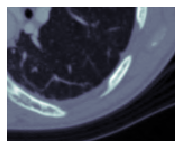

In [155]:
scaled = scaled_px(patient6)
crop = scaled[280:400,300:450]
show_image(crop, cmap='bone');

Scale down even further (picture above is to illustrate the area of the image we are looking at)

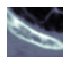

In [156]:
cropped = scaled[340:385,300:350]
show_image(cropped, cmap='bone');

We can now plot each pixel value

In [239]:
df = pd.DataFrame(cropped)
#uncomment below to view locally
#df.style.set_properties(**{'font-size':'8pt'}).background_gradient('bone').format("{:.1f}")

![pre_windowed](my_icons/pre.PNG)

Using the lung window which has a `window width` of 1500 and a `window level` of -600.

- lowest_visible_value = **-600 - (1500/2) = -1350**
- highest_visible_value = **-600 + (1500/2) = +150**

In this case the lowest_visible_value will be `-1350` and the highest_visible_value of `+150`. This means that every pixel value greater than `+150` will show up as white and any value below `-1350` will show up as black.

In [240]:
windowed_image = cropped.windowed(*dicom_windows.lungs)

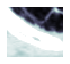

In [201]:
show_image(windowed_image, cmap=plt.cm.bone);

In [238]:
dfs = pd.DataFrame(windowed_image)
#uncomment below to view locally
#dfs.style.set_properties(**{'font-size':'6pt'}).background_gradient('bone').format("{:.1f}")

![post_windowed](my_icons/post.PNG)

The pixel intensities have been scaled to values within the window range. To check that the window range is working as planned we can compare the pixel values of the original and the windowed image.  Any pixel value above `+150` will show up as white and any pixel value below `-1350` will show up as black with various shades between those values.

In [185]:
#original image
df[1:2].style.set_properties(**{'font-size':'8pt'}).format("{:.1f}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
1,234.0,71.0,-91.0,-297.0,-486.0,-611.0,-655.0,-637.0,-637.0,-662.0,-674.0,-621.0,-557.0,-469.0,-420.0,-456.0,-582.0,-670.0,-708.0,-728.0,-734.0,-731.0,-721.0,-734.0,-742.0,-740.0,-743.0,-748.0,-751.0,-746.0,-737.0,-723.0,-710.0,-710.0,-718.0,-723.0,-717.0,-712.0,-689.0,-617.0,-510.0,-356.0,-219.0,-197.0,-351.0,-589.0,-711.0,-737.0,-720.0,-731.0


In [187]:
#windowed image
dfs[1:2].style.set_properties(**{'font-size':'8pt'}).format("{:.1f}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
1,1.0,0.9,0.8,0.7,0.6,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.6,0.6,0.6,0.5,0.5,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.5,0.6,0.7,0.8,0.8,0.7,0.5,0.4,0.4,0.4,0.4


Starting with the first pixel on the left, pixel value of `234` is higher than the highest_visible_value of `+150` so this pixel will show up as white on the windowed image (represented by a `1.0`).  The pixel value at column 21 is `-731` which is not below the lowest_visible_value of `-1350` so will not be shown as black but is represented by a shaded color(depending on the cmap setting) with a value of `0.4`.

### Significance of changing window settings

**Window Width**

- Increasing the window width will `decrease` the contrast of the image
- Decreasing the window width will `increase` the contrast of the image

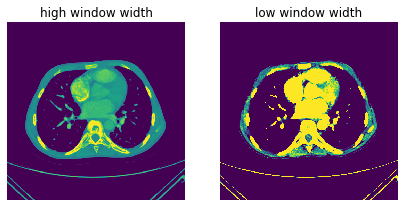

In [232]:
high_width = patient6.windowed(w=1000, l=40)
low_width = patient6.windowed(w=100, l=40)

show_images([high_width, low_width], titles=['high window width', 'low window width'], figsize=(7,7))

**Window Level**

- Increasing the window level will `decrease` the brightness of the image
- Decreasing the window level will `increase` the brightness of the image

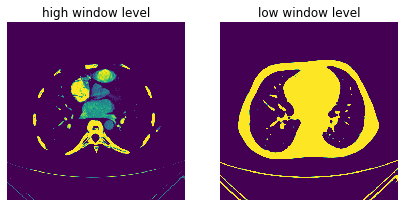

In [234]:
high_level = patient6.windowed(w=200, l=200)
low_level = patient6.windowed(w=200, l=-200)

show_images([high_level, low_level], titles=['high window level', 'low window level'], figsize=(7,7))

### Various window ranges

There are numerous window ranges as specified in `dicom_windows` or you could create your own by specifying the `window width` and `window center`. These are the most common window ranges used when particularly looking at images of the lungs.

#### Lung Window

- Window settings: (W:1600, L:-600)
- Usually used with a wide window to provide good resolution and to visualize a wide variety of densities.

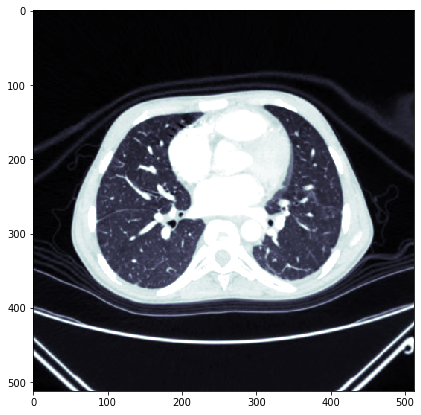

In [4]:
lung = plt.imshow(patient6.windowed(*dicom_windows.lungs), cmap=plt.cm.bone); lung;

#### Mediastinum Window

- Window settings: (W:500, L:50)
- The mediastinum is the area that separates the lungs. It is surrounded by the breastbone in front and the spine in back, with the lungs on either side. It encompasses the heart, aorta, esophagus, thymus (a gland in the back of the neck) and trachea (windpipe).

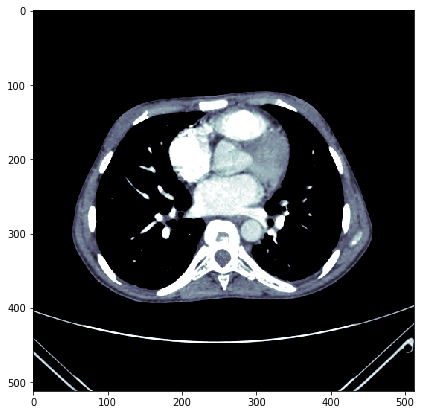

In [6]:
mediastinum = plt.imshow(patient6.windowed(*dicom_windows.mediastinum), cmap=plt.cm.bone); mediastinum;

#### PE Window

- Window settings: (W:700, L:100) - this is not part of `dicom_windows` but you can easily use custom window ranges by specifying the `window level` and `window width`
- Window range specifically used for looking at pulmonary embolisms

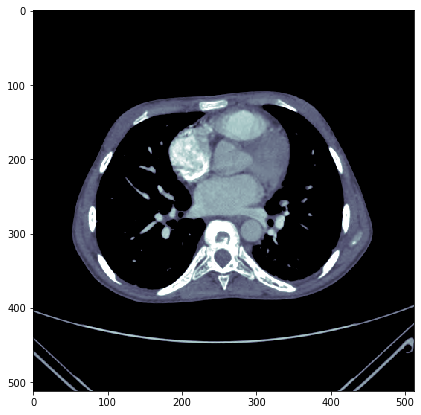

In [7]:
pe = plt.imshow(patient6.windowed(l=100, w=700), cmap=plt.cm.bone); pe;

Each window highlights particular ranges that make it easier for a radiologist to see if there are any changes between normal and pathologically altered tissue. If we compare the 3 images above with a non-windowed image we can clearly see why windowing is important.

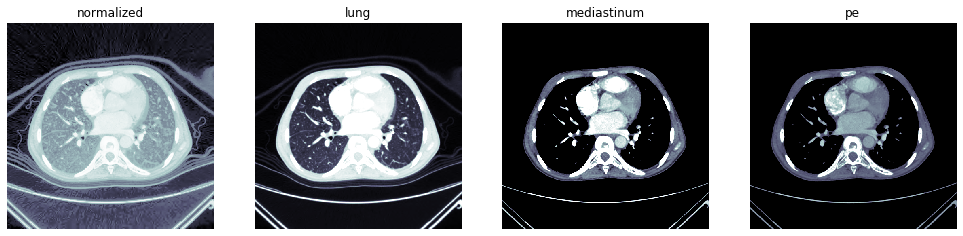

In [34]:
show_images([patient6.hist_scaled(), patient6.windowed(*dicom_windows.lungs),patient6.windowed(*dicom_windows.mediastinum),\
             patient6.windowed(l=100, w=700)], titles=['normalized', 'lung', 'mediastinum', 'pe'], figsize=(17,17));

## References

<sup>1</sup>[Increasing the Number of Gray Shades in Medical Display Systems—How Much is Enough?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3043920/)

<sup>2</sup>[Understanding CT windows, levels and densities](https://www.youtube.com/watch?v=KZld-5W99cI)

<sup>3</sup>[Hounsfield scale](https://en.wikipedia.org/wiki/Hounsfield_scale)

<sup>4</sup>[Image Credit](https://web.archive.org/web/20070926231241/http://www.intl.elsevierhealth.com/e-books/pdf/940.pdf)